In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score,  roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, K2Score
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator

from tqdm import tqdm

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
# Load the dataset
data = pd.read_csv('./Data_aggregated_29-08-2024.csv')

# Define features and target
data = data.drop(['id', 'rms_nm_std_avg',
             'rms_nm_std_med', 'rms_nm_std_std', 'rms_nm_std_min',
             'rms_nm_std_max'], axis=1)

data['stage'] = data['stage'].str.lower()
data['stage'] = (data['stage'].isin(['iiia', 'iiib', 'iiic'])).astype(int)  # 1 for late stage, 0 for early stage
data['subtype'] = (data['subtype'] == 2).astype(int)  # 1 is one type, 2 is the other

def comma_to_float(value):
    try:
        return float(value.replace(',', '.'))
    except:
        return value

numeric_features = ['age', 'size_cm', 'packyears', 'pd-l1', 'foxp3']
for feature in ['elasticity_nucleus_mpa_', 'elasticity_cytoplasm_mpa_', 'cell_width_microm_',
                'cell_cytoplasm_height_', 'cell_nucleus_height_', 'rms_nm_']:
    for statistic in ['avg', 'med', 'std', 'min', 'max']:
        if statistic != 'avg':
            data = data.drop([feature+statistic], axis=1)
        else:
            numeric_features.append(feature+statistic)
            data[feature+statistic] = data[feature+statistic].apply(comma_to_float)

categorical_features = ['gender', 'grade', 'subtype']
binary_features = ['lvi', 'vi', 'pni', 'pii', 'egfr', 'ros1', 'alk', 'ntrk', 'gender', 'stage']

In [49]:
# Prepare the data by converting continuous variables to categorical
def get_bin_edges(series, bins=4):
    non_nan = series.dropna()
    if len(non_nan) == 0:
        return None
    
    bin_edges = np.percentile(non_nan, np.linspace(0, 100, bins + 1))
    return bin_edges

def discretize_with_nan(series, bins, print_ranges=False):
    non_nan = series.dropna()
    if len(non_nan) == 0:
        return pd.Series(index=series.index)
    
    bin_edges = np.percentile(non_nan, np.linspace(0, 100, bins + 1))
    bin_edges[0] = -np.inf
    bin_edges[-1] = np.inf
    
    labels = ['Low', 'Medium-Low', 'Medium-High', 'High']
    discretized = pd.cut(series, bins=bin_edges, labels=labels, include_lowest=True)
    discretized = discretized.cat.add_categories('Unknown')
    discretized = discretized.fillna('Unknown')

    if print_ranges:
        print(series.name)
        print(f"Low: <= {bin_edges[1]:.2f}")
        print(f"Medium-Low: {bin_edges[1]:.2f} to {bin_edges[2]:.2f}")
        print(f"Medium-High: {bin_edges[2]:.2f} to {bin_edges[3]:.2f}")
        print(f"High: > {bin_edges[3]:.2f}")
        print()
    
    return discretized

for var in numeric_features:
    if var in data.columns:
        data[var] = discretize_with_nan(data[var], bins=4, print_ranges=True)

age
Low: <= 62.00
Medium-Low: 62.00 to 68.00
Medium-High: 68.00 to 72.00
High: > 72.00

size_cm
Low: <= 3.20
Medium-Low: 3.20 to 4.20
Medium-High: 4.20 to 4.90
High: > 4.90

packyears
Low: <= 18.00
Medium-Low: 18.00 to 24.00
Medium-High: 24.00 to 28.00
High: > 28.00

pd-l1
Low: <= 0.00
Medium-Low: 0.00 to 18.00
Medium-High: 18.00 to 62.00
High: > 62.00

foxp3
Low: <= 12.00
Medium-Low: 12.00 to 18.00
Medium-High: 18.00 to 42.00
High: > 42.00

elasticity_nucleus_mpa_avg
Low: <= 3.35
Medium-Low: 3.35 to 9.01
Medium-High: 9.01 to 15.40
High: > 15.40

elasticity_cytoplasm_mpa_avg
Low: <= 4.47
Medium-Low: 4.47 to 10.68
Medium-High: 10.68 to 12.67
High: > 12.67

cell_width_microm_avg
Low: <= 41.13
Medium-Low: 41.13 to 52.14
Medium-High: 52.14 to 57.65
High: > 57.65

cell_cytoplasm_height_avg
Low: <= 539.17
Medium-Low: 539.17 to 699.77
Medium-High: 699.77 to 896.79
High: > 896.79

cell_nucleus_height_avg
Low: <= 1651.91
Medium-Low: 1651.91 to 1999.06
Medium-High: 1999.06 to 2521.26
High: > 252

In [53]:
# Learn a structure
scoring_method = K2Score(data=data)
est = HillClimbSearch(data=data)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4)
)
print("Learned structure:", list(estimated_model.edges()))

  1%|          | 67/10000 [00:01<03:29, 47.33it/s]

Learned structure: [('gender', 'subtype'), ('gender', 'packyears'), ('gender', 'alk'), ('age', 'cell_nucleus_height_avg'), ('subtype', 'alk'), ('subtype', 'rms_nm_avg'), ('size_cm', 'packyears'), ('size_cm', 'age'), ('size_cm', 'rms_nm_avg'), ('size_cm', 'gender'), ('packyears', 'cell_width_microm_avg'), ('packyears', 'cell_nucleus_height_avg'), ('stage', 'vi'), ('stage', 'size_cm'), ('stage', 'gender'), ('pd-l1', 'foxp3'), ('lvi', 'grade'), ('lvi', 'alk'), ('lvi', 'pii'), ('vi', 'lvi'), ('pni', 'pd-l1'), ('pni', 'grade'), ('pni', 'size_cm'), ('pni', 'alk'), ('pni', 'pii'), ('pii', 'foxp3'), ('pii', 'pd-l1'), ('pii', 'age'), ('pii', 'grade'), ('pii', 'size_cm'), ('egfr', 'gender'), ('ros1', 'stage'), ('ros1', 'egfr'), ('ntrk', 'vi'), ('ntrk', 'egfr'), ('ntrk', 'pii'), ('ntrk', 'stage'), ('grade', 'rms_nm_avg'), ('grade', 'subtype'), ('elasticity_nucleus_mpa_avg', 'cell_cytoplasm_height_avg'), ('elasticity_nucleus_mpa_avg', 'elasticity_cytoplasm_mpa_avg'), ('elasticity_nucleus_mpa_avg',

In [59]:
# Learned structure
structure = [('gender', 'subtype'), ('gender', 'packyears'), 
             ('age', 'rms_nm_avg'), ('age', 'packyears'), ('age', 'gender'), 
             ('size_cm', 'packyears'), ('size_cm', 'age'), ('size_cm', 'elasticity_nucleus_mpa_avg'), 
             ('packyears', 'cell_cytoplasm_height_avg'), ('packyears', 'rms_nm_avg'), 
             ('stage', 'size_cm'), ('stage', 'pii'), 
             ('pd-l1', 'foxp3'), ('pd-l1', 'cell_width_microm_avg'), 
             ('lvi', 'vi'), ('lvi', 'alk'), ('lvi', 'grade'), ('lvi', 'pii'), 
             ('vi', 'stage'), ('vi', 'elasticity_nucleus_mpa_avg'), 
             ('pni', 'pd-l1'), ('pni', 'subtype'), ('pni', 'elasticity_nucleus_mpa_avg'), ('pni', 'grade'), ('pni', 'size_cm'), ('pni', 'alk'), ('pni', 'pii'), ('pni', 'vi'), 
             ('pii', 'pd-l1'), ('pii', 'foxp3'), ('pii', 'cell_width_microm_avg'), ('pii', 'age'), ('pii', 'elasticity_nucleus_mpa_avg'), ('pii', 'grade'), ('pii', 'size_cm'), 
             ('ros1', 'egfr'), ('alk', 'subtype'), ('ntrk', 'stage'), ('ntrk', 'size_cm'), ('ntrk', 'egfr'), ('ntrk', 'pii'), 
             ('grade', 'rms_nm_avg'), ('grade', 'age'), 
             ('elasticity_nucleus_mpa_avg', 'cell_nucleus_height_avg'), ('elasticity_nucleus_mpa_avg', 'elasticity_cytoplasm_mpa_avg'), ('elasticity_nucleus_mpa_avg', 'cell_cytoplasm_height_avg'), 
             ('elasticity_nucleus_mpa_avg', 'foxp3'), ('elasticity_nucleus_mpa_avg', 'cell_width_microm_avg'), ('elasticity_nucleus_mpa_avg', 'pd-l1'), ('elasticity_nucleus_mpa_avg', 'rms_nm_avg'), 
             ('elasticity_nucleus_mpa_avg', 'packyears'), ('elasticity_nucleus_mpa_avg', 'age'), ('elasticity_nucleus_mpa_avg', 'grade'), 
             ('elasticity_cytoplasm_mpa_avg', 'cell_nucleus_height_avg'), ('elasticity_cytoplasm_mpa_avg', 'foxp3'), ('elasticity_cytoplasm_mpa_avg', 'alk'), 
             ('cell_width_microm_avg', 'cell_nucleus_height_avg'), ('cell_width_microm_avg', 'elasticity_cytoplasm_mpa_avg'), ('cell_width_microm_avg', 'cell_cytoplasm_height_avg'), 
             ('cell_cytoplasm_height_avg', 'cell_nucleus_height_avg'), ('cell_cytoplasm_height_avg', 'elasticity_cytoplasm_mpa_avg'), 
             ('rms_nm_avg', 'elasticity_cytoplasm_mpa_avg'), ('rms_nm_avg', 'cell_cytoplasm_height_avg'), ('rms_nm_avg', 'cell_width_microm_avg'), ('rms_nm_avg', 'pd-l1'), ('rms_nm_avg', 'ros1')]

In [57]:
# Devised structure from literature
structure = [
    # Demographic and Clinical Factors
    ('age', 'subtype'), ('gender', 'subtype'), ('packyears', 'subtype'),
    ('packyears', 'egfr'),
    
    # Cancer Characteristics
    ('subtype', 'stage'), ('subtype', 'grade'), ('subtype', 'size_cm'),
    ('stage', 'size_cm'), ('grade', 'stage'),
    
    # Invasion and Metastasis
    ('stage', 'lvi'), ('stage', 'vi'), ('stage', 'pni'),
    ('size_cm', 'lvi'), ('size_cm', 'vi'),
    
    # Immune Response
    ('subtype', 'pd-l1'), ('stage', 'pd-l1'),
    ('subtype', 'foxp3'), ('stage', 'foxp3'),
    ('pd-l1', 'foxp3'),
    ('subtype', 'pii'), ('stage', 'pii'),
    
    # Genetic Biomarkers
    ('subtype', 'egfr'), ('subtype', 'alk'), ('subtype', 'ros1'), ('subtype', 'ntrk'),
    ('stage', 'egfr'),
    
    # Biophysical Properties
    ('stage', 'elasticity_nucleus_mpa_avg'), ('stage', 'elasticity_cytoplasm_mpa_avg'),
    ('grade', 'elasticity_cytoplasm_mpa_avg'),
    ('vi', 'elasticity_nucleus_mpa_avg'), ('pni', 'elasticity_cytoplasm_mpa_avg'),
    ('stage', 'rms_nm_avg'),
    ('stage', 'cell_width_microm_avg'),
    ('stage', 'cell_nucleus_height_avg'), ('stage', 'cell_cytoplasm_height_avg'),
    ('pni', 'cell_cytoplasm_height_avg'), ('vi', 'cell_nucleus_height_avg')
]

/tmp/ipykernel_1768620/971833273.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


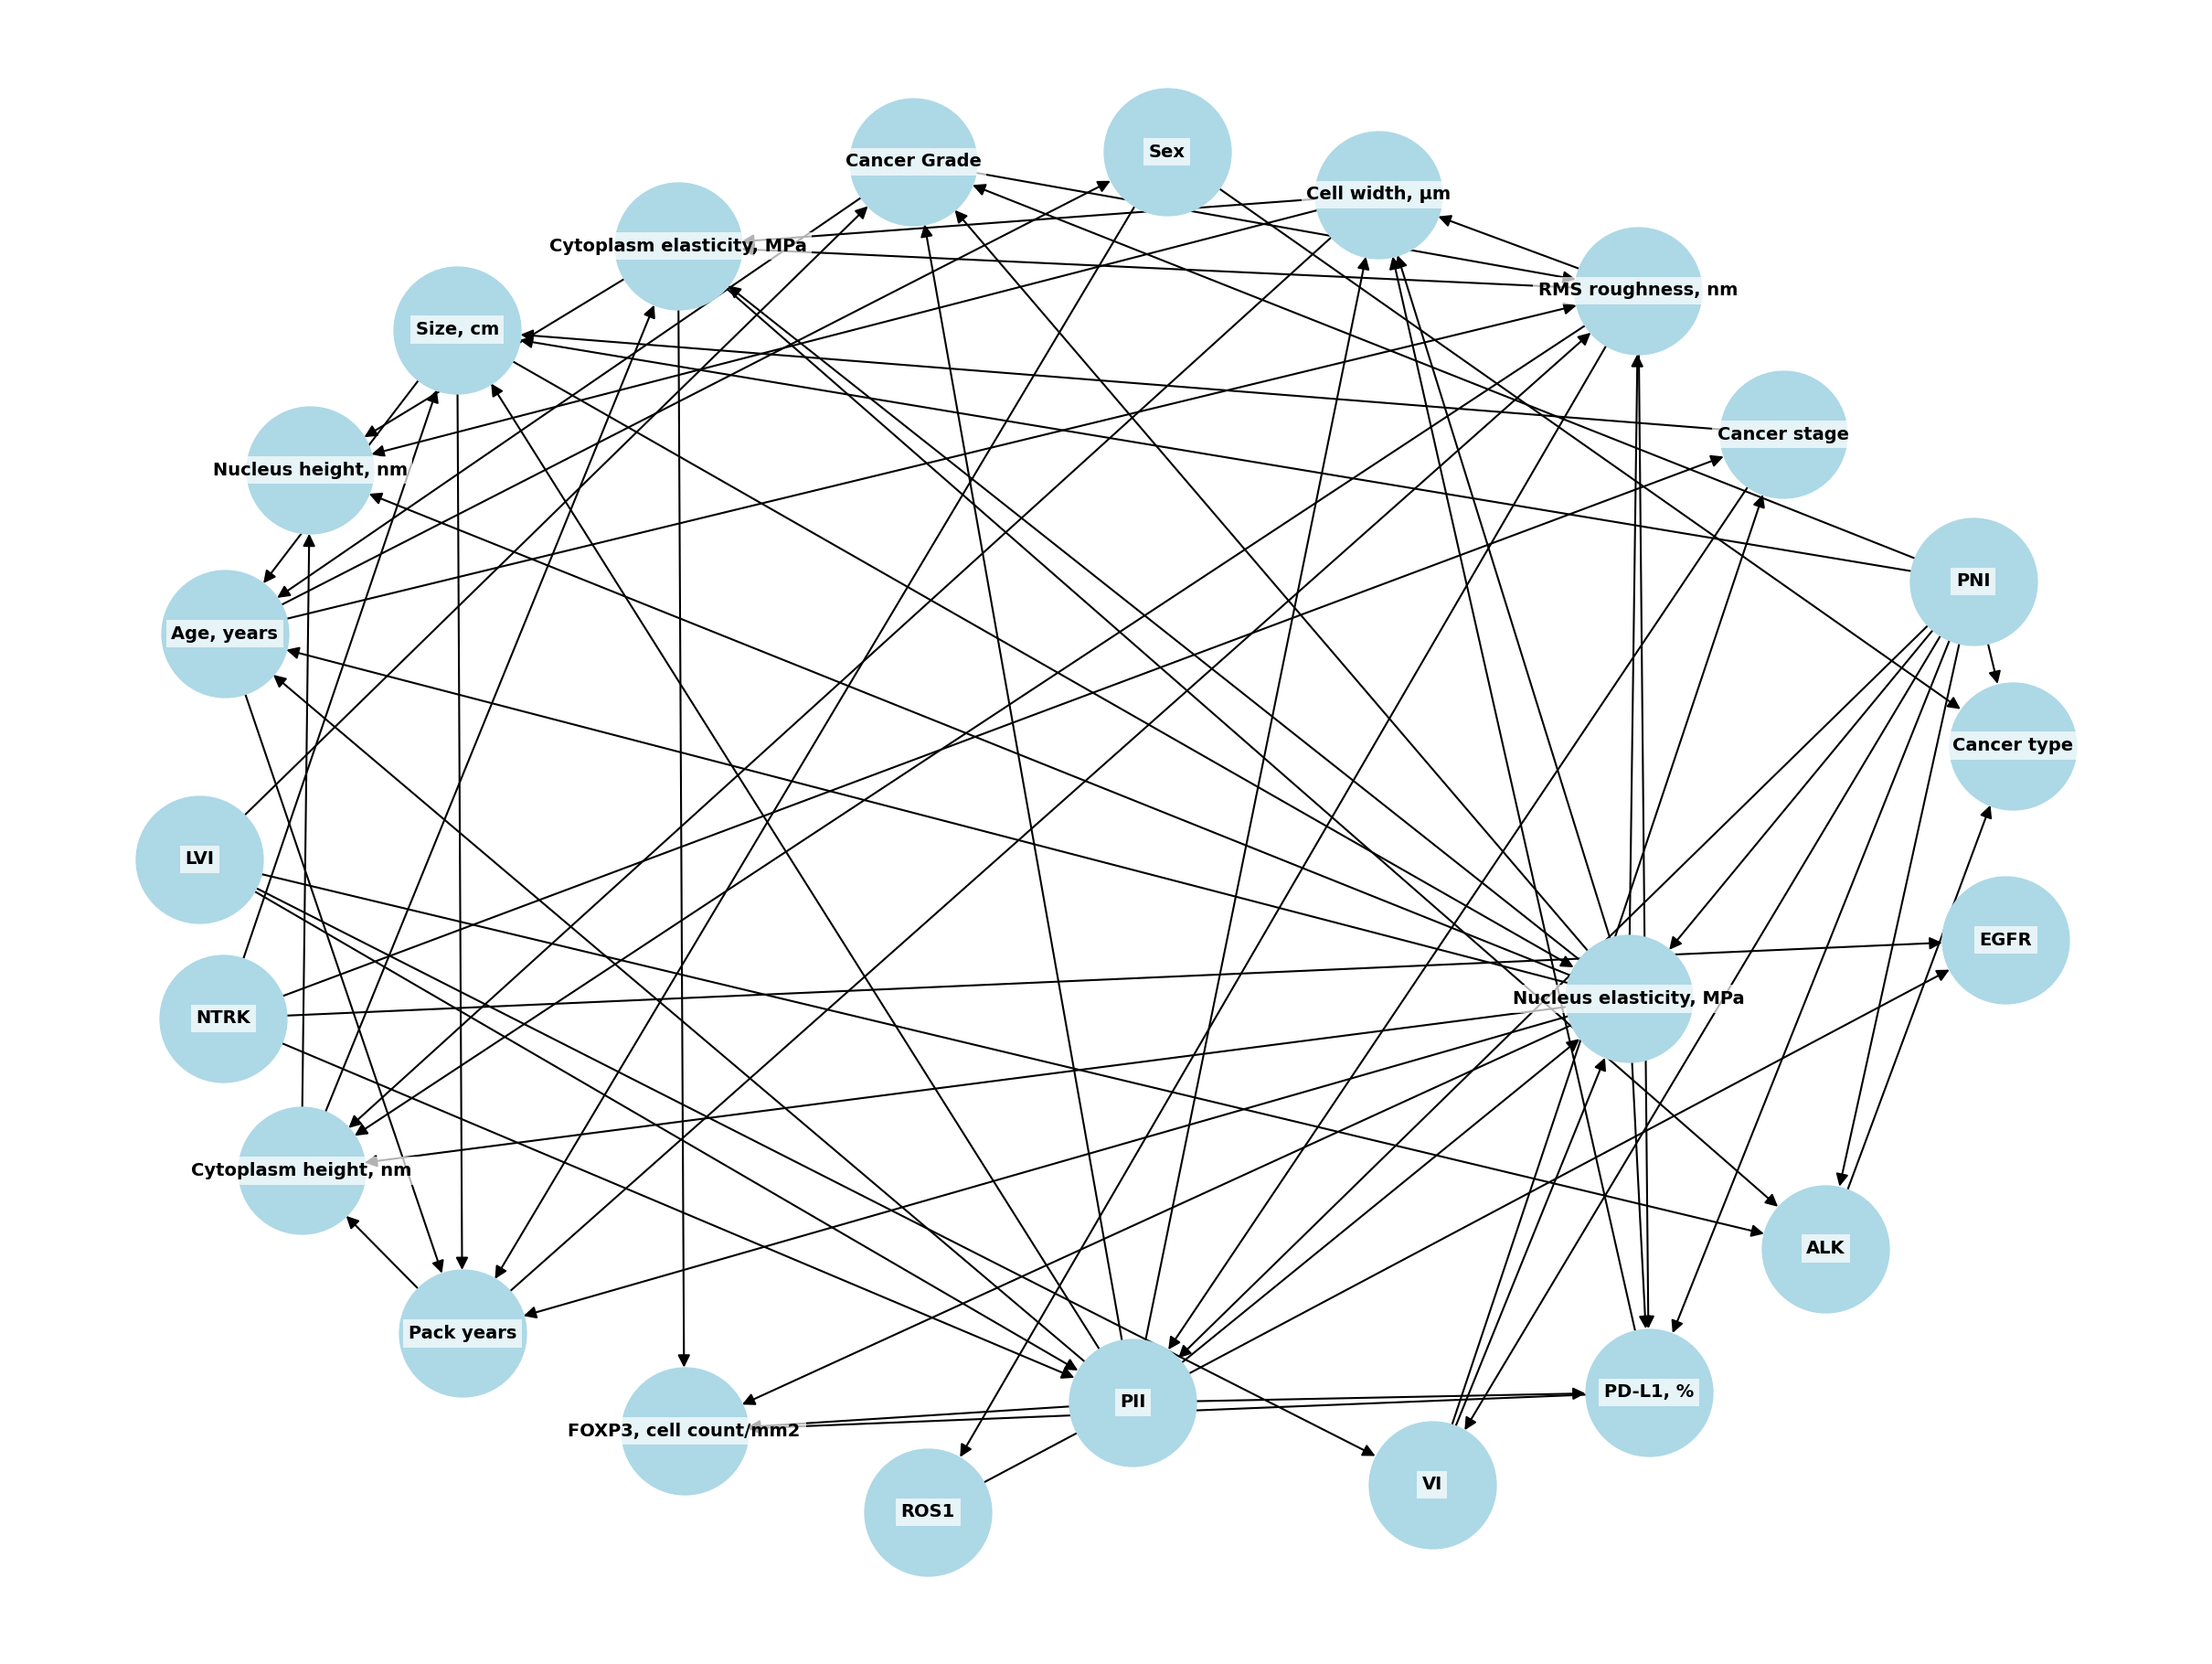

In [34]:
feature_name_mapping = {
    'age': 'Age, years',
    'gender': 'Sex',
    'packyears': 'Pack years',
    'subtype': 'Cancer type',
    'stage': 'Cancer stage',
    'grade': 'Cancer Grade',
    'size_cm': 'Size, cm',
    'pd-l1': 'PD-L1, %',
    'lvi': 'LVI',
    'vi': 'VI',
    'pni': 'PNI',
    'pii': 'PII',
    'foxp3': 'FOXP3, cell count/mm2',
    'egfr': 'EGFR',
    'ros1': 'ROS1',
    'alk': 'ALK',
    'ntrk': 'NTRK',
    'elasticity_nucleus_mpa_avg': 'Nucleus elasticity, MPa',
    'elasticity_cytoplasm_mpa_avg': 'Cytoplasm elasticity, MPa',
    'cell_width_microm_avg': 'Cell width, μm',
    'cell_cytoplasm_height_avg': 'Cytoplasm height, nm',
    'cell_nucleus_height_avg': 'Nucleus height, nm',
    'rms_nm_avg': 'RMS roughness, nm'
}

# Update the structure with the new names
updated_structure = [(feature_name_mapping.get(edge[0], edge[0]), 
                      feature_name_mapping.get(edge[1], edge[1])) 
                     for edge in structure]

import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()
G.add_edges_from(updated_structure)

# Set up the plot
plt.figure(figsize=(24, 18))
pos = nx.spring_layout(G, k=10, iterations=200, seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=False, node_color='lightblue', 
        node_size=10000, 
        arrows=True, edge_color='black', width=1.5,  
        arrowsize=20)

# Add labels with a white background for better readability
labels = nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')
for label in labels.values():
    label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.7))

# plt.title("Bayesian Network Structure", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()

Performing LOOCV:   0%|          | 0/37 [00:00<?, ?it/s]

Performing LOOCV: 100%|██████████| 37/37 [00:01<00:00, 20.51it/s]

Average Log-Likelihood: -0.4089873101316
Standard Deviation of Log-Likelihood: 0.8642150034529547
Accuracy in predicting subtype: 0.8918918918918919
Precision: 0.8918918918918919
Sens: 0.8823529411764706
Spec: 0.9
F1 Score: 0.8918918918918919
ROC AUC: 0.8470588235294118


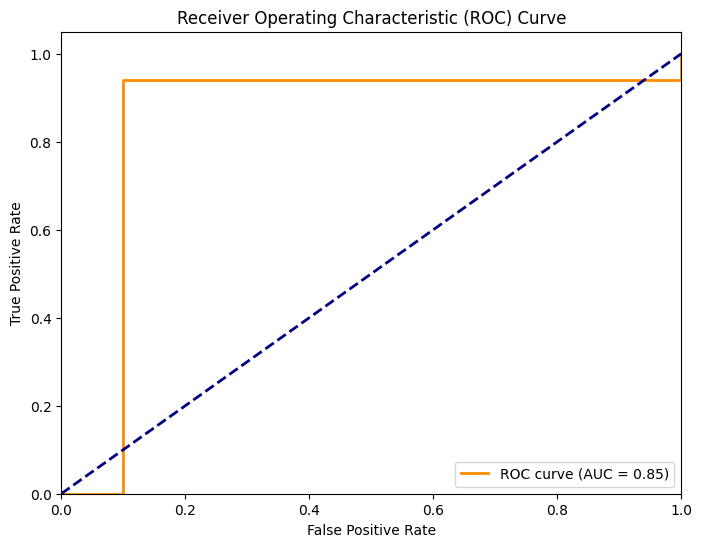

ROC AUC: 0.8470588235294118


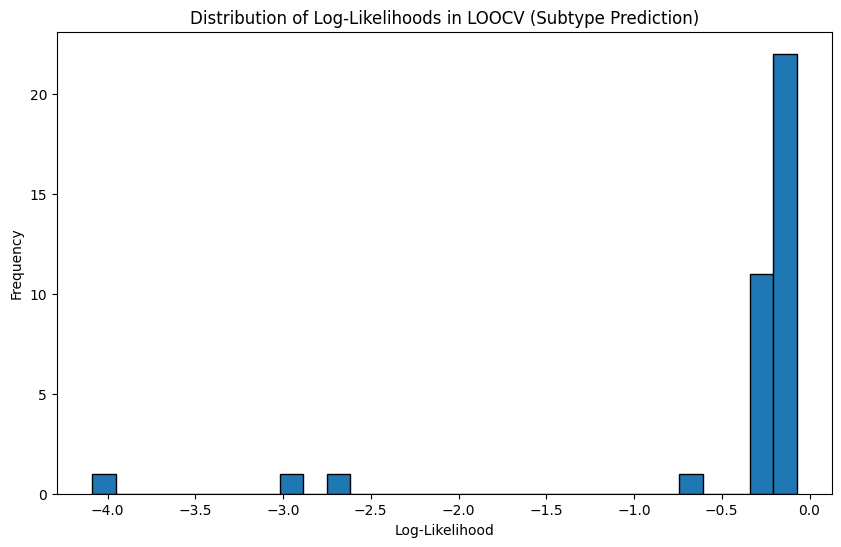

In [60]:
def calculate_subtype_log_likelihood(model, data):
    inference = VariableElimination(model)
    log_likelihood = 0
    for _, row in data.iterrows():
        evidence = row.drop('subtype').to_dict()
        cpd = inference.query(['subtype'], evidence=evidence)
        prob = cpd.values[row['subtype']]
        log_likelihood += np.log(prob)
    return log_likelihood

def loocv_bayesian_network_subtype(data, structure):
    log_likelihoods = []
    predictions = []
    actuals = []
    probabilities = []
    n_samples = len(data)
    n_classes = len(data['subtype'].unique())
    
    for i in tqdm(range(n_samples), desc="Performing LOOCV"):
        # Split the data
        train_data = data.drop(data.index[i])
        test_data = data.iloc[[i]]
        
        # Create and train the model
        model = BayesianNetwork(structure)
        model.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")
        
        # Calculate log-likelihood for the left-out sample
        log_likelihood = calculate_subtype_log_likelihood(model, test_data)
        log_likelihoods.append(log_likelihood)
        
        # Make prediction for subtype
        inference = VariableElimination(model)
        evidence = test_data.drop('subtype', axis=1).iloc[0].to_dict()
        pred_cpd = inference.query(['subtype'], evidence=evidence)
        prediction = pred_cpd.values.argmax()
        predictions.append(prediction)
        actuals.append(test_data['subtype'].iloc[0])
        probabilities.append(pred_cpd.values)
    
    # Calculate metrics
    avg_log_likelihood = np.mean(log_likelihoods)
    tn, fp, fn, tp = confusion_matrix(actuals, predictions).ravel()
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions, average='weighted')
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(actuals, predictions, average='weighted')
    
    # Calculate ROC AUC
    actuals_bin = label_binarize(actuals, classes=range(n_classes))
    if n_classes == 2:
        roc_auc = roc_auc_score(actuals_bin, np.array(probabilities)[:, 1])
    else:
        roc_auc = roc_auc_score(actuals_bin, np.array(probabilities), multi_class='ovr', average='weighted')
    
    return avg_log_likelihood, log_likelihoods, accuracy, precision, sensitivity, specificity, f1, roc_auc, actuals_bin, np.array(probabilities), actuals, predictions

# Assuming 'data' is your DataFrame and 'structure' is your network structure
avg_ll, all_ll, acc, precision, sensitivity, specificity, f1, roc_auc, actuals_bin, probabilities, actuals, predictions = loocv_bayesian_network_subtype(data, structure)

print(f"Average Log-Likelihood: {avg_ll}")
print(f"Standard Deviation of Log-Likelihood: {np.std(all_ll)}")
print(f"Accuracy in predicting subtype: {acc}")
print(f"Precision: {precision}")
print(f"Sens: {sensitivity}")
print(f"Spec: {specificity}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Reshape actuals_bin to be a 1D array
actuals_bin = actuals_bin.ravel()
# Use only the probabilities for the positive class (second column)
positive_probs = probabilities[:, 1]
# Calculate ROC AUC
roc_auc = roc_auc_score(actuals_bin, positive_probs)
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(actuals_bin, positive_probs)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc}")

# Plot log-likelihood distribution
plt.figure(figsize=(10, 6))
plt.hist(all_ll, bins=30, edgecolor='black')
plt.title("Distribution of Log-Likelihoods in LOOCV (Subtype Prediction)")
plt.xlabel("Log-Likelihood")
plt.ylabel("Frequency")
plt.show()